In [1]:
import xarray as xr
import numpy as np
import datetime
import pandas as pd
import gsw
from scipy import interpolate

import matplotlib as mpl
import matplotlib.pyplot as plt


In [2]:
################################################################################
########    DICTIONARIES
################################################################################

reg_ext = {
    'lab': {
        'lon' : (-60, -30),
        'lat' : (50, 65),
        'name' : 'Labrador and Irminger Seas'
    },
    'gul': {
        'lon' : (-75, -45),
        'lat' : (30, 45),
        'name' : 'Gulf Stream'
    },
    'noe': {
        'lon' : (-30, -5),
        'lat' : (45, 60),
        'name' : 'North East Sea'
    }
}

## Selected points in the regions
### Gulf S: (60W, 35N)
### Lab -I: (50W, 55N)
### Nor E: (17.5W, 52.5N)
points = {
    'gul': {
        'lon': -60., 
        'lat': 35.
    },
    'lab': {
        'lon': -50., 
        'lat': 55.
    },
    'noe': {
        'lon': -17.5, 
        'lat': 52.5}
}


gulf = {
    12 : {
        't': (17.5, 19.), 
        's': (36.4, 37),
        'd': (26.3, 26.6)
    },
    25 : {
        't': (17.5, 25.), 
        's': (36.25, 36.75),
        'd': (24., 27.)
    },
    38 : {
        't': (17.5, 26.), 
        's': (36.4, 36.8),
        'd': (24., 26.5)
    },
    51 : {
        't': (18., 22.2), 
        's': (36.4, 36.7),
        'd': (25., 26.5)
    }
}


labrador = {
    12 : {
        't': (2.75, 3.5), 
        's': (34.65, 34.85),
        'd': (27.6, 27.75)
    },
    25 : {
        't': (3., 8.), 
        's': (34.5, 35.),
        'd': (26., 29.)
    },
    38 : {
        't': (3., 11.), 
        's': (34.5, 35.),
        'd': (26., 28.)
    },
    51 : {
        't': (4., 5.5), 
        's': (34.25, 35.),
        'd': (27.2, 27.7)
    }
}


north = {
    12 : {
        't': (10.7, 11.7), 
        's': (35.35, 35.5),
        'd': (26.9, 27.3)
    },
    25 : {
        't': (10., 15.), 
        's': (35.3, 35.7),
        'd': (26.2, 27.2)
    },
    38 : {
        't': (11., 16.), 
        's': (35.3, 35.7),
        'd': (26., 28.)
    },
    51 : {
        't': (11., 13.), 
        's': (35.45, 35.65),
        'd': (26.8, 27.2)
    }
}


mld_lines = {
    'MLDa' : {
        'color' : 'k',
        'linestyle' :'solid', 
        'linewidth' : 3
    },
    'MLDf' : {
        'color' : 'm', 
        'linestyle' : 'solid', 
        'linewidth' : 3
    },
    'MLDv' : {
        'color' : 'c', 
        'linestyle' : 'solid', 
        'linewidth' : 1
    },
    'MLDint' : {
        'color' : 'r', 
        'linestyle' : 'dashdot', 
        'linewidth' : 2
    }
}

In [3]:
################################################################################
########    FUNCTIONS
################################################################################

## Function to make the (x,y)-> (lon,lat) grid
def Grid(data_set):
    """
        Grid is a function that creates a rectangular grid using as x a longitude
        array and for y a latitude array.
        
        Parameters:
        ------------
            
        data_set : DataArray
            Is the dataset from which we will plot the histogram.
        
        Output:
        -------
        (x, y) : n-arrays
            Arrays that correspond for each (lon,lat) point
    """
    x = data_set.longitude
    y = data_set.latitude
    
    x, y = np.meshgrid(x, y)
    return(x, y)



## Function to crop the dataset
def Crops(coord, d_set):
    """
        Crops is a function that takes a data set and crops it into smaller
        region, using as parameters the values given by the dictionary 
        reg_ext.
        
        Parameters:
        ------------
            
        coord : string
            Key value that identifies the region to obtain
        
        d_set : DataArray
            Dataset to be cropped
        
        Output:
        -------
        new_ds : DataArray
            New data array corresponding to the region stated by 'coord'
    """
    
    lon1, lon2 = reg_ext[coord]['lon']
    lat1, lat2 = reg_ext[coord]['lat']
    name_fig = reg_ext[coord]['name']
    
    new_ds = d_set.sel(longitude=slice(lon1, lon2), latitude=slice(lat1, lat2))
    return(new_ds)


def Limits(dictionary, t):
    a = dictionary[t]['t']
    b = dictionary[t]['s']
    c = dictionary[t]['d']
    
    return(a, b, c)

def Convert(data_set, t=None):
    dep = - data_set.depth
    sal = data_set.so.values
    tem = data_set.to.values
    lon = float(data_set.longitude.values)
    lat = float(data_set.latitude.values)
    
    # Pressure -> depth latitudde
    pr = gsw.p_from_z(dep, lat)
    sa = gsw.conversions.SA_from_SP(sal, pr, lon, lat)
    ct = gsw.conversions.CT_from_t(sa, tem, pr)
    ds = gsw.density.sigma0(sa, ct)

    return(dep, sa, ct, ds, pr)


def New_density(tem_10, sal_10, pss_10):
    pot_10 = gsw.pt0_from_t(sal_10, tem_10, pss_10)
    dpt = pot_10 - 0.2

    tem_02 = gsw.conversions.CT_from_pt(sal_10, dpt)
    ds_02 = gsw.density.sigma0(sal_10, tem_02)

    return (ds_02, tem_02)


def Point(data_set, coord):
    point = data_set.sel(longitude=points[coord]['lon'], 
           latitude=points[coord]['lat'], method='nearest')
    return(point)


#Function to calculate MLD, according to a threshold value
def ML_depth(depth, density, delta):

    for i in range(2, len(density)):
        diff = density[i] - density[1]
        if (diff >= delta):
            return(float(depth[i]), i)
            break

            

def Densities_delta(den, tem, sal, pss, t):
    # Calculating the density at dT = 0.2 degrees
    # pot temp_10, sal_10m -> New density at dT = 0.2
    den10 = den[1]
    tem10 = tem[1]
    sal10 = sal[1]
    pre10 = pre[1]

    den02, tem02 = New_density(tem10, sal10, pre10)
    dDv = den02 - den10
    
    return(den02, dDv)

In [4]:
################ PLOTS
## dep, tem, sal, ds_g

def Plot_density(ax, dep, tem, sal, den, depth, t=None, name=None, **mld_values):
    """
        Plot_density is a function that plots the vertical profiles of
        density, temperature and salinity. It also draws horizontal lines
        indicating the position of the MLD, given the values.    
        
        Parameters:
        ------------
            
        ax : axes.Axes object
            Current axes in which we make the draw.
            
        dep : Array
            Array with the depth coordinates. Positive going upwards.
        
        tem : Array
            Temperature [oC] profile values.
        
        sal : Array
            Salinity [PSU] profile values.
        
        depth : float
            Limit on y-axis.
        
        t : int
            Number of week that corresponds to the plot. This value works together
            with the function 'Limits(reg_name, t)', retrieving the correct axis
            limits. If None, the axis imits are automatically set.
        
        name : string
            Saving name for the output plot. It is recomended to include the path of 
            objective directory. If None, the plot is not saved, and just shown. 
        
        mld_values : float [kwarg]
            Is the list of the MLD estimations. To draw horizontal lines.
            
    """
    lims_t = (np.nanmin(tem[0:14])-0.5, np.nanmax(tem[0:14])+0.5)
    lims_s = (np.nanmin(sal[0:14])-0.05, np.nanmax(sal[0:14])+0.05)
    lims_d = (np.nanmin(den[0:14])-0.1, np.nanmax(den[0:14])+0.1)
    
    # Temperature
    color = 'orange'
    ax.set_xlabel('Temperature [$^o$C]', color=color)
    ax.set_ylabel('Depth [m]')
    ax.plot(tem, dep, color=color)
    ax.tick_params(axis='x', labelcolor=color)
    ax.set_xlim(lims_t)
    
    #xmin = tem.min(skipna=True).values
    #xmax = tem.max(skipna=True).values
    
    for mld, v in mld_values.items(): 
        cl = mld_lines[mld]['color']
        ls = mld_lines[mld]['linestyle']
        lw = mld_lines[mld]['linewidth']
        ax.hlines(v, lims_t[0], lims_t[1], colors=cl, linestyles=ls, linewidths=lw )

    # Salinity
    color = 'blue'
    ax2 = ax.twiny()
    ax2.set_xlabel('Salinity [PSU]', color=color)  
    ax2.plot(sal, dep, color=color)
    ax2.tick_params(axis='x', labelcolor=color)
    ax2.set_xlim(lims_s)
    
    # Density
    color = 'green'
    ax3 = ax.twiny()
    ax3.set_xlabel('Density [kg m$^{-3}$]', color=color)
    ax3.plot(den, dep, color=color)
    ax3.spines["top"].set_position(("axes", 1.10))
    ax3.tick_params(axis='x', labelcolor=color)
    ax3.set_xlim(lims_d)
    
    plt.ylim(depth, 0)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped

    if name:
        plt.savefig(name)
        

In [5]:
def Year_sel(data_set, yr):
    """
        Year_sel slects an specific year from a dataset.  
        
        Parameters:
        ------------
            
        data_set : DataArray
            Array from we extract the year.
        
        yr : int
            Number of the year we want 
        
        Output:
        ------------
        y : dataArray
            DataArray containing only the data corresponding to yr
            
    """
    cond = data_set.time.dt.year.isin([yr])
    y = data_set.sel(time=cond)
    
    return(y)

def Point_sel(data_set, lon, lat, isel=True):
    """
        Point_sel selects a point given the latitude and longitude, or the 
        index of the array. The default function is using isel. If sel() wants
        to be used, the nearest method is used to select the point.
        
        
        Parameters:
        ------------
            
        data_set : DataArray
            Array from we extract the year.
        
        lon : float
            Coordinate for longitude.
        
        lat : float
            Coordinate for latitude.
        
        Output:
        ------------
        p : dataArray
            DataArray containing only the data corresponding to (lon, lat)
            
    """
    if isel:
        p = data_set.isel(longitude=lon, latitude=lat)
    else:
        p = data_set.sel(longitude=lon, latitude=lat, method='nearest')
    
    return(p)


def Inversion(den):
    """
        Inversion is a function that evaluates if the vertical profile in a
        grid point contains a density inversion. The criterion used here is
        that the density at 10m is greater or equal to 0.05kg/m3.
        
        Parameters:
        ------------
            
        den : DataArray
            Density array.
        
        
        Output:
        ------------
        0/1 : integer
            Returns 0 if no inversion found.
            Returns 1 is an inversion is found.
            
    """
    eps = 0.1
    l = 2
    diff = 0.01
    
    while diff <= eps:
        diff = den[1] - den[l]
        l += 1
        
        if l == 13:
            #print(l, diff)
            return(0)
            break
            
    #print(l, diff)
    return(1)
    
    #for l in range(2, 14):
    #    diff = den[1]- den[l]
    #    if diff >= eps:
    #        print(l, diff, den[1], den[l])
    #        return(1)
    #        break
    
        
        
    

In [6]:
###############################################################################
###########         MAIN PROGRAM
###############################################################################

dir_1 = '../../data_ARMOR/'
dir_2 = '../Vertical-prof/'
fl_n1 = 'ARMOR_*.nc'

c_armor = xr.open_mfdataset(dir_1 + fl_n1)

## Selected points in the regions
### Gulf S: (60W, 35N)
### Lab -I: (50W, 55N)
### Nor E: (17.5W, 52.5N)

gl = Crops('gul', c_armor)
lb = Crops('lab', c_armor)
nr = Crops('noe', c_armor)

/venv/py3-phyocean/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  if __name__ == '__main__':
/venv/py3-phyocean/lib/python3.6/site-packages/xarray/backends/api.py:933: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


In [7]:
# Time step we work on:: 12, 25, 38, 51
p_gl = Point(gl, 'gul')
place = gulf
t = 12


In [ ]:
# Convert(data_set, t) -> (dep, sal, tem, den, temp_pot)
dep, sal, tem, den, pre = Convert(p_gl, t)

## Calculating the deltas
dn02_gl, Ddv_gl = Densities_delta(den, tem, sal, pre, t)
Ddf_gl = 0.03

MLD_a = p_gl.mlotst[t].values
MLD_f, jf = ML_depth(dep, den, Ddf_gl)
MLD_v, jv = ML_depth(dep, den, Ddv_gl)

# Calculating depth from density :: Interpolation
x = den[jv-1:jv+2]
y = dep[jv-1:jv+2]
dep_dens = interpolate.interp1d(x, y, kind='linear')

MLD_int = dep_dens(dn02_gl)
print("MDL by ARMOR: % 5.2f" %(MLD_a))
print("MDL fixed: % 5.2f" %(MLD_f))
print("MDL by variable: % 5.2f" %(MLD_v))
print("MDL by variable+interpolation: % 5.2f" %(MLD_int))


mld_values =  {'MLDa' : - MLD_a, 'MLDf' : MLD_f, 'MLDv' : MLD_v, 'MLDint' : MLD_int}

## reg_name:: gulf, labrador, north

## Making plot
#name_fig = dir_2 + 'Gulf-'+ str(t)+'.png'

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 9))
Plot_density(ax, dep, tem, sal, den, -500., t=None, name=None, **mld_values)

plt.show()

## Selecting the anomalous point: (50W, 42N)

In [8]:
## Here the dataset is gl!!

lon = -50.
lat = 42.
dl = 0.25

p0 = Point_sel(gl, lon, lat, isel=False)

print(p0.longitude.values, p0.latitude.values)
p0

-49.875 42.125


<xarray.Dataset>
Dimensions:    (depth: 33, time: 730)
Coordinates:
    longitude  float32 -49.875
    latitude   float32 42.125
  * depth      (depth) float64 0.0 10.0 20.0 30.0 ... 4.5e+03 5e+03 5.5e+03
  * time       (time) datetime64[ns] 2005-01-05 2005-01-12 ... 2018-12-26
Data variables:
    mlotst     (time) float32 dask.array<chunksize=(52,), meta=np.ndarray>
    so         (time, depth) float32 dask.array<chunksize=(52, 33), meta=np.ndarray>
    to         (time, depth) float32 dask.array<chunksize=(52, 33), meta=np.ndarray>
    ugo        (time, depth) float32 dask.array<chunksize=(52, 33), meta=np.ndarray>
    vgo        (time, depth) float32 dask.array<chunksize=(52, 33), meta=np.ndarray>
    zo         (time, depth) float32 dask.array<chunksize=(52, 33), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version ?? (http://mpimet.mpg.de/cdi)
    Conventions:  CF-1.0
    history:      Mon Mar  9 15:25:32 2020: ncks -d latitude,10.,85. -d longi...
    institution:  CLS
    description:  ARMOR3D REP CMEMS - April 2019 Release
    title:        ARMOR3D REP - TSHUVMld Global Ocean Observation-based Product
    domain_name:  GLO
    CDO:          Climate Data Operators version 1.9.3 (http://mpimet.mpg.de/...
    NCO:          4.7.2

In [9]:
## selecting the year, as a check

p0_2008 = Year_sel(p0, 2008)



# Checking in 2008

## The points around the anomalous

In [10]:
## So here, I have the coordinates of the center point p0. It is already selected
## We are going to select other 4 points arrounf the central one, in the same year
## to see how they are behaving. Also from here I should check the vertical profile.
## This points contain all years.


## Dataset filtered this region correspond to 

p1 = Point_sel(gl, lon, lat+dl, isel=False)
p2 = Point_sel(gl, lon+dl, lat, isel=False)
p3 = Point_sel(gl, lon, lat-dl, isel=False)
p4 = Point_sel(gl, lon-dl, lat, isel=False)

p0_2008 = Year_sel(p0, 2008)
p1_2008 = Year_sel(p1, 2008)
p2_2008 = Year_sel(p2, 2008)
p3_2008 = Year_sel(p3, 2008)
p4_2008 = Year_sel(p4, 2008)

In [11]:
p0_2008.mlotst[10].values

array(356.30005, dtype=float32)

In [12]:
t0 = p0_2008.mlotst.argmax(dim='time', skipna=True).values

In [13]:
p0_2008.depth[13].values

array(500.)

## Making a mask for the density inversions

In [15]:
nt = gl.time.size
nlon = gl.longitude.size
nlat = gl.latitude.size

inv = np.empty((nt, nlon, nlat))
print(nlon, nlat)

120 60


In [16]:
point = gl.isel(longitude=6, latitude=5)

In [ ]:
# Convert(data_set, t) -> (dep, sal, tem, den, temp_pot)

#for ti in range(nt):
#    print(ti)
#    for lo in range(nlon):
#        for la in range(nlat):
#            point = Point_sel(gl, lo, la, isel=True)
#            dep, sal, tem, den, pre = Convert(point, ti)
#            inv[ti,lo,la] = Inversion(dep)#
#
#            del den
#            del sal
#            del tem
#            del pre

## Masking using percentiles

In [19]:
percents = gl.mlotst.std(dim='time').reduce(np.nanpercentile, 
                                              q=98, dim=('longitude', 'latitude'))

mask_i = 1 * np.ones((gl.dims['latitude'], 
                    gl.dims['longitude'])) * (gl.mlotst.std(dim='time') >= percents) 
gl.coords['mask_i'] = (('latitude', 'longitude'), mask_i)

print(percents)

/venv/py3-phyocean/lib/python3.6/site-packages/dask/array/core.py:1333: FutureWarning: The `numpy.nanpercentile` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  FutureWarning,
/venv/py3-phyocean/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/venv/py3-phyocean/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/venv/py3-phyocean/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)
/venv/py3-phyocean/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.DataArray 'mlotst' ()>
array(133.73160919)


/venv/py3-phyocean/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)


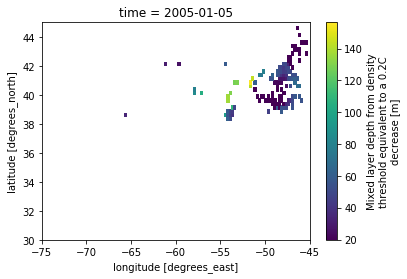

In [18]:
spurious = gl.where(gl.mask_i==1)

spurious.mlotst[0].plot()

In [30]:

smally = gl.sel(longitude=slice(-47, -46), latitude=slice(41,42)).mean(dim='time')

nt = 26
nlon = 4
nlat = 4

smally

<xarray.Dataset>
Dimensions:    (depth: 33, latitude: 4, longitude: 4)
Coordinates:
  * longitude  (longitude) float32 -46.875 -46.625 -46.375 -46.125
  * latitude   (latitude) float32 41.125 41.375 41.625 41.875
  * depth      (depth) float64 0.0 10.0 20.0 30.0 ... 4.5e+03 5e+03 5.5e+03
    mask_i     (latitude, longitude) float64 1.0 1.0 1.0 0.0 ... 1.0 0.0 0.0 0.0
Data variables:
    mlotst     (latitude, longitude) float32 dask.array<chunksize=(4, 4), meta=np.ndarray>
    so         (depth, latitude, longitude) float32 dask.array<chunksize=(33, 4, 4), meta=np.ndarray>
    to         (depth, latitude, longitude) float32 dask.array<chunksize=(33, 4, 4), meta=np.ndarray>
    ugo        (depth, latitude, longitude) float32 dask.array<chunksize=(33, 4, 4), meta=np.ndarray>
    vgo        (depth, latitude, longitude) float32 dask.array<chunksize=(33, 4, 4), meta=np.ndarray>
    zo         (depth, latitude, longitude) float32 dask.array<chunksize=(33, 4, 4), meta=np.ndarray>

In [31]:
# Convert(data_set, t) -> (dep, sal, tem, den, temp_pot)

inv2 = np.empty((nlon, nlat))
print(nlon, nlat)
ti = 0
#for ti in range(nt):
#print(ti)
for lo in range(nlon):
    print(lo)
    for la in range(nlat):
        point = Point_sel(smally, lo, la, isel=True)
        dep, sal, tem, den, pre = Convert(point, t=None)
        inv2[lo, la] = Inversion(den)
        del den
        del sal
        del tem
        del pre


4 4
0


/venv/py3-phyocean/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/venv/py3-phyocean/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/venv/py3-phyocean/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/venv/py3-phyocean/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/venv/py3-phyocean/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/venv/py3-phyocean/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/venv/py3-phyoce

1


/venv/py3-phyocean/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/venv/py3-phyocean/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/venv/py3-phyocean/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/venv/py3-phyocean/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/venv/py3-phyocean/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/venv/py3-phyocean/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/venv/py3-phyoce

2


/venv/py3-phyocean/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/venv/py3-phyocean/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/venv/py3-phyocean/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/venv/py3-phyocean/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/venv/py3-phyocean/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/venv/py3-phyocean/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/venv/py3-phyoce

3


/venv/py3-phyocean/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/venv/py3-phyocean/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/venv/py3-phyocean/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/venv/py3-phyocean/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/venv/py3-phyocean/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/venv/py3-phyocean/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/venv/py3-phyoce

In [ ]:
plt.close()
x, y = Grid(smally)
#for ti in range(nt):
ii = plt.contourf(inv2, levels=np.linspace(0., 1., 3))
plt.colorbar(ii)
plt.title('inversions 1')
plt.show()

In [ ]:
P

##  Vertical profile of central point

In [ ]:
p0 = p0_2008
t0 = p0_2008.mlotst.argmax(dim='time', skipna=True).values
print(t0)

In [ ]:
# Convert(data_set, t) -> (dep, sal, tem, den, temp_pot)
dep, sal, tem, den, pre = Convert(p0, t0)

## Calculating the deltas
dn02_gl, Ddv_gl = Densities_delta(den, tem, sal, pre, t0)
Ddf_gl = 0.03

MLD_a = p0.mlotst[t0].values
MLD_f, jf = ML_depth(dep, den, Ddf_gl)
MLD_v, jv = ML_depth(dep, den, Ddv_gl)

# Calculating depth from density :: Interpolation
x = den[jv-1:jv+2]
y = dep[jv-1:jv+2]
dep_dens = interpolate.interp1d(x, y, kind='linear')

MLD_int = dep_dens(dn02_gl)
print("MDL by ARMOR: % 5.2f" %(MLD_a))
print("MDL fixed: % 5.2f" %(MLD_f))
print("MDL by variable: % 5.2f" %(MLD_v))
print("MDL by variable+interpolation: % 5.2f" %(MLD_int))


mld_values =  {'MLDa' : - MLD_a, 'MLDf' : MLD_f, 'MLDv' : MLD_v, 'MLDint' : MLD_int}

## reg_name:: gulf, labrador, north

In [ ]:
## Making plot
#name_fig = dir_2 + 'Gulf-'+ str(t)+'.png'

plt.close()
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 9))
Plot_density(ax, dep, tem, sal, den, -500., t=None, name=None, **mld_values)

plt.show()

### Point up

In this case, t is always the same than for the central point

In [ ]:
p1 = p1_2008
t1 = p0_2008.mlotst.argmax(dim='time', skipna=True).values
print(t1)

In [ ]:
# Convert(data_set, t) -> (dep, sal, tem, den, temp_pot)
dep, sal, tem, den, pre = Convert(p1, t1)

## Calculating the deltas
dn02_gl, Ddv_gl = Densities_delta(den, tem, sal, pre, t1)
Ddf_gl = 0.03

MLD_a = p1.mlotst[t1].values
MLD_f, jf = ML_depth(dep, den, Ddf_gl)
MLD_v, jv = ML_depth(dep, den, Ddv_gl)

# Calculating depth from density :: Interpolation
x = den[jv-1:jv+2]
y = dep[jv-1:jv+2]
dep_dens = interpolate.interp1d(x, y, kind='linear')

MLD_int = dep_dens(dn02_gl)
print("MDL by ARMOR: % 5.2f" %(MLD_a))
print("MDL fixed: % 5.2f" %(MLD_f))
print("MDL by variable: % 5.2f" %(MLD_v))
print("MDL by variable+interpolation: % 5.2f" %(MLD_int))


mld_values =  {'MLDa' : - MLD_a, 'MLDf' : MLD_f, 'MLDv' : MLD_v, 'MLDint' : MLD_int}

## reg_name:: gulf, labrador, north

In [ ]:
## Making plot
#name_fig = dir_2 + 'Gulf-'+ str(t)+'.png'

plt.close()
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 9))
Plot_density(ax, dep, tem, sal, den, -500., t=None, name=None, **mld_values)

plt.show()

### Point rigth

In [ ]:
p1 = p2_2008
t1 = p0_2008.mlotst.argmax(dim='time', skipna=True).values
print(t1)

In [ ]:
# Convert(data_set, t) -> (dep, sal, tem, den, temp_pot)
dep, sal, tem, den, pre = Convert(p1, t1)

## Calculating the deltas
dn02_gl, Ddv_gl = Densities_delta(den, tem, sal, pre, t1)
Ddf_gl = 0.03

MLD_a = p1.mlotst[t1].values
MLD_f, jf = ML_depth(dep, den, Ddf_gl)
MLD_v, jv = ML_depth(dep, den, Ddv_gl)

# Calculating depth from density :: Interpolation
x = den[jv-1:jv+2]
y = dep[jv-1:jv+2]
dep_dens = interpolate.interp1d(x, y, kind='linear')

MLD_int = dep_dens(dn02_gl)
print("MDL by ARMOR: % 5.2f" %(MLD_a))
print("MDL fixed: % 5.2f" %(MLD_f))
print("MDL by variable: % 5.2f" %(MLD_v))
print("MDL by variable+interpolation: % 5.2f" %(MLD_int))


mld_values =  {'MLDa' : - MLD_a, 'MLDf' : MLD_f, 'MLDv' : MLD_v, 'MLDint' : MLD_int}

## reg_name:: gulf, labrador, north

In [ ]:
## Making plot
#name_fig = dir_2 + 'Gulf-'+ str(t)+'.png'

plt.close()
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 9))
Plot_density(ax, dep, tem, sal, den, -500., t=None, name=None, **mld_values)

plt.show()

### Point Down

In [ ]:
p1 = p3_2008
t1 = p0_2008.mlotst.argmax(dim='time', skipna=True).values
print(t1)

In [ ]:
# Convert(data_set, t) -> (dep, sal, tem, den, temp_pot)
dep, sal, tem, den, pre = Convert(p1, t1)

## Calculating the deltas
dn02_gl, Ddv_gl = Densities_delta(den, tem, sal, pre, t1)
Ddf_gl = 0.03

MLD_a = p1.mlotst[t1].values
MLD_f, jf = ML_depth(dep, den, Ddf_gl)
MLD_v, jv = ML_depth(dep, den, Ddv_gl)

# Calculating depth from density :: Interpolation
x = den[jv-1:jv+2]
y = dep[jv-1:jv+2]
dep_dens = interpolate.interp1d(x, y, kind='linear')

MLD_int = dep_dens(dn02_gl)
print("MDL by ARMOR: % 5.2f" %(MLD_a))
print("MDL fixed: % 5.2f" %(MLD_f))
print("MDL by variable: % 5.2f" %(MLD_v))
print("MDL by variable+interpolation: % 5.2f" %(MLD_int))


mld_values =  {'MLDa' : - MLD_a, 'MLDf' : MLD_f, 'MLDv' : MLD_v, 'MLDint' : MLD_int}

## reg_name:: gulf, labrador, north

In [ ]:
## Making plot
#name_fig = dir_2 + 'Gulf-'+ str(t)+'.png'

plt.close()
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 9))
Plot_density(ax, dep, tem, sal, den, -600., t=None, name=None, **mld_values)

plt.show()

### Point left

In [ ]:
p1 = p4_2008
t1 = p0_2008.mlotst.argmax(dim='time', skipna=True).values
print(t1)

In [ ]:
# Convert(data_set, t) -> (dep, sal, tem, den, temp_pot)
dep, sal, tem, den, pre = Convert(p1, t1)

## Calculating the deltas
dn02_gl, Ddv_gl = Densities_delta(den, tem, sal, pre, t1)
Ddf_gl = 0.03

MLD_a = p1.mlotst[t1].values
MLD_f, jf = ML_depth(dep, den, Ddf_gl)
MLD_v, jv = ML_depth(dep, den, Ddv_gl)

# Calculating depth from density :: Interpolation
x = den[jv-1:jv+2]
y = dep[jv-1:jv+2]
dep_dens = interpolate.interp1d(x, y, kind='linear')

MLD_int = dep_dens(dn02_gl)
print("MDL by ARMOR: % 5.2f" %(MLD_a))
print("MDL fixed: % 5.2f" %(MLD_f))
print("MDL by variable: % 5.2f" %(MLD_v))
print("MDL by variable+interpolation: % 5.2f" %(MLD_int))


mld_values =  {'MLDa' : - MLD_a, 'MLDf' : MLD_f, 'MLDv' : MLD_v, 'MLDint' : MLD_int}

## reg_name:: gulf, labrador, north

In [ ]:
## Making plot
#name_fig = dir_2 + 'Gulf-'+ str(t)+'.png'

plt.close()
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 9))
Plot_density(ax, dep, tem, sal, den, -500., t=None, name=None, **mld_values)

plt.show()

## Checking 2017

In [ ]:
p0_2017 = Year_sel(p0, 2017)

In [ ]:
t = p0_2017.mlotst.argmax(dim='time', skipna=True).values
print(t)

In [ ]:
p = p0_2017
# Convert(data_set, t) -> (dep, sal, tem, den, temp_pot)

dep, sal, tem, den, pre = Convert(p, t)

## Calculating the deltas
dn02_gl, Ddv_gl = Densities_delta(den, tem, sal, pre, t)
Ddf_gl = 0.03

MLD_a = p.mlotst[t].values
MLD_f, jf = ML_depth(dep, den, Ddf_gl)
MLD_v, jv = ML_depth(dep, den, Ddv_gl)

# Calculating depth from density :: Interpolation
x = den[jv-1:jv+2]
y = dep[jv-1:jv+2]
dep_dens = interpolate.interp1d(x, y, kind='linear')

MLD_int = dep_dens(dn02_gl)
print("MDL by ARMOR: % 5.2f" %(MLD_a))
print("MDL fixed: % 5.2f" %(MLD_f))
print("MDL by variable: % 5.2f" %(MLD_v))
print("MDL by variable+interpolation: % 5.2f" %(MLD_int))


mld_values =  {'MLDa' : - MLD_a, 'MLDf' : MLD_f, 'MLDv' : MLD_v, 'MLDint' : MLD_int}

## reg_name:: gulf, labrador, north

In [ ]:
## Making plot
#name_fig = dir_2 + 'Gulf-'+ str(t)+'.png'
plt.close()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 9))
Plot_density(ax, dep, tem, sal, den, -400., t=None, name=None, **mld_values)

plt.show()

##  Checking 2014

In [ ]:
p0_2014 = Year_sel(p0, 2014)

In [ ]:
t = p0_2014.mlotst.argmax(dim='time', skipna=True).values
print(t)

In [ ]:
p = p0_2014
# Convert(data_set, t) -> (dep, sal, tem, den, temp_pot)
dep, sal, tem, den, pre = Convert(p, t)

## Calculating the deltas
dn02_gl, Ddv_gl = Densities_delta(den, tem, sal, pre, t)
Ddf_gl = 0.03

MLD_a = p.mlotst[t].values
MLD_f, jf = ML_depth(dep, den, Ddf_gl)
MLD_v, jv = ML_depth(dep, den, Ddv_gl)

# Calculating depth from density :: Interpolation
x = den[jv-1:jv+2]
y = dep[jv-1:jv+2]
dep_dens = interpolate.interp1d(x, y, kind='linear')

MLD_int = dep_dens(dn02_gl)
print("MDL by ARMOR: % 5.2f" %(MLD_a))
print("MDL fixed: % 5.2f" %(MLD_f))
print("MDL by variable: % 5.2f" %(MLD_v))
print("MDL by variable+interpolation: % 5.2f" %(MLD_int))


mld_values =  {'MLDa' : - MLD_a, 'MLDf' : MLD_f, 'MLDv' : MLD_v, 'MLDint' : MLD_int}

## reg_name:: gulf, labrador, north

In [ ]:
## Making plot
#name_fig = dir_2 + 'Gulf-'+ str(t)+'.png'

plt.close()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 9))
Plot_density(ax, dep, tem, sal, den, -200., t=None, name=None, **mld_values)

plt.show()

## Checking 2013

In [ ]:
p0_2013 = Year_sel(p0, 2013)

In [ ]:
t = p0_2013.mlotst.argmax(dim='time', skipna=True).values
print(t)

In [ ]:
p = p0_2013
# Convert(data_set, t) -> (dep, sal, tem, den, temp_pot)
dep, sal, tem, den, pre = Convert(p, t)

## Calculating the deltas
dn02_gl, Ddv_gl = Densities_delta(den, tem, sal, pre, t)
Ddf_gl = 0.03

MLD_a = p.mlotst[t].values
MLD_f, jf = ML_depth(dep, den, Ddf_gl)
MLD_v, jv = ML_depth(dep, den, Ddv_gl)

# Calculating depth from density :: Interpolation
x = den[jv-1:jv+2]
y = dep[jv-1:jv+2]
dep_dens = interpolate.interp1d(x, y, kind='linear')

MLD_int = dep_dens(dn02_gl)
print("MDL by ARMOR: % 5.2f" %(MLD_a))
print("MDL fixed: % 5.2f" %(MLD_f))
print("MDL by variable: % 5.2f" %(MLD_v))
print("MDL by variable+interpolation: % 5.2f" %(MLD_int))


mld_values =  {'MLDa' : - MLD_a, 'MLDf' : MLD_f, 'MLDv' : MLD_v, 'MLDint' : MLD_int}

## reg_name:: gulf, labrador, north

In [ ]:
## Making plot
#name_fig = dir_2 + 'Gulf-'+ str(t)+'.png'

plt.close()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 9))
Plot_density(ax, dep, tem, sal, den, -200., t=None, name=None, **mld_values)

plt.show()

### What about a not 'extreme' value?

In [ ]:
t = 22  #This is a not extreme value

In [ ]:
p = p0_2013
# Convert(data_set, t) -> (dep, sal, tem, den, temp_pot)
dep, sal, tem, den, pre = Convert(p, t)

## Calculating the deltas
dn02_gl, Ddv_gl = Densities_delta(den, tem, sal, pre, t)
Ddf_gl = 0.03

MLD_a = p.mlotst[t].values
MLD_f, jf = ML_depth(dep, den, Ddf_gl)
MLD_v, jv = ML_depth(dep, den, Ddv_gl)

# Calculating depth from density :: Interpolation
x = den[jv-1:jv+2]
y = dep[jv-1:jv+2]
dep_dens = interpolate.interp1d(x, y, kind='linear')

MLD_int = dep_dens(dn02_gl)
print("MDL by ARMOR: % 5.2f" %(MLD_a))
print("MDL fixed: % 5.2f" %(MLD_f))
print("MDL by variable: % 5.2f" %(MLD_v))
print("MDL by variable+interpolation: % 5.2f" %(MLD_int))


mld_values =  {'MLDa' : - MLD_a, 'MLDf' : MLD_f, 'MLDv' : MLD_v, 'MLDint' : MLD_int}

## reg_name:: gulf, labrador, north

In [ ]:
## Making plot
#name_fig = dir_2 + 'Gulf-'+ str(t)+'.png'

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 9))
Plot_density(ax, dep, tem, sal, den, -200., t=None, name=None, **mld_values)

plt.show()

## Checking 2011

In [ ]:
p0_2011 = Year_sel(p0, 2011)

In this case, the maximum value of the MLD along the year corresponds to the maximum in March, that falls in the range od the std. The one chosen here, t=40, corresponds to a MLD value that is larger than the std.

In [ ]:
t = 40 #p0_2011.mlotst.argmax(dim='time', skipna=True).values
print(t)

In [ ]:
p = p0_2011
# Convert(data_set, t) -> (dep, sal, tem, den, temp_pot)
dep, sal, tem, den, pre = Convert(p, t)

## Calculating the deltas
dn02_gl, Ddv_gl = Densities_delta(den, tem, sal, pre, t)
Ddf_gl = 0.03

MLD_a = p.mlotst[t].values
MLD_f, jf = ML_depth(dep, den, Ddf_gl)
MLD_v, jv = ML_depth(dep, den, Ddv_gl)

# Calculating depth from density :: Interpolation
x = den[jv-1:jv+2]
y = dep[jv-1:jv+2]
dep_dens = interpolate.interp1d(x, y, kind='linear')

MLD_int = dep_dens(dn02_gl)
print("MDL by ARMOR: % 5.2f" %(MLD_a))
print("MDL fixed: % 5.2f" %(MLD_f))
print("MDL by variable: % 5.2f" %(MLD_v))
print("MDL by variable+interpolation: % 5.2f" %(MLD_int))


mld_values =  {'MLDa' : - MLD_a, 'MLDf' : MLD_f, 'MLDv' : MLD_v, 'MLDint' : MLD_int}

## reg_name:: gulf, labrador, north

In [ ]:
## Making plot
#name_fig = dir_2 + 'Gulf-'+ str(t)+'.png'

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 9))
Plot_density(ax, dep, tem, sal, den, -200., t=None, name=None, **mld_values)

plt.show()

In [ ]:
t = 9 #p0_2011.mlotst.argmax(dim='time', skipna=True).values
print(t)

In [ ]:
p = p0_2011
# Convert(data_set, t) -> (dep, sal, tem, den, temp_pot)
dep, sal, tem, den, pre = Convert(p, t)

## Calculating the deltas
dn02_gl, Ddv_gl = Densities_delta(den, tem, sal, pre, t)
Ddf_gl = 0.03

MLD_a = p.mlotst[t].values
MLD_f, jf = ML_depth(dep, den, Ddf_gl)
MLD_v, jv = ML_depth(dep, den, Ddv_gl)

# Calculating depth from density :: Interpolation
x = den[jv-1:jv+2]
y = dep[jv-1:jv+2]
dep_dens = interpolate.interp1d(x, y, kind='linear')

MLD_int = dep_dens(dn02_gl)
print("MDL by ARMOR: % 5.2f" %(MLD_a))
print("MDL fixed: % 5.2f" %(MLD_f))
print("MDL by variable: % 5.2f" %(MLD_v))
print("MDL by variable+interpolation: % 5.2f" %(MLD_int))


mld_values =  {'MLDa' : - MLD_a, 'MLDf' : MLD_f, 'MLDv' : MLD_v, 'MLDint' : MLD_int}

## reg_name:: gulf, labrador, north

In [ ]:
## Making plot
#name_fig = dir_2 + 'Gulf-'+ str(t)+'.png'
plt.close()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 9))
Plot_density(ax, dep, tem, sal, den, -200., t=None, name=None, **mld_values)

plt.show()